<h1 style="text-align: center;">Eniviornmental Sensor</h1>


The enviornmental sensor can provide four different types of measurements:
* Humidity
* Air Pressure
* Temperature
* Gas Resistance

The gas resistance measurment requires a hot plate inside the sensor to be heated.
This can effect the results of the other readings, so this measurement is taken last, after all the others. If gas resistance readings are not being taken, then you can sample much more frequently as you do not have to worry about the effect of the hot plate.

You will need to have the following packages installed in your enviornment:
- bme680
- numpy
- matplotlib

You can make sure these packages are up to date by runing the following cell:  
(Using a '!' at the start of a line allows you to run bash commands from a Jupyter Notebook)

In [2]:
! python3 -m pip install --upgrade bme680
! python3 -m pip install --upgrade numpy
! python3 -m pip install --upgrade matplotlib

---

## Setup:

In [4]:
import bme680
import time
import numpy as np
from matplotlib import pyplot as plt

sensor = bme680.BME680()

sensor.set_humidity_oversample(bme680.OS_2X)
sensor.set_pressure_oversample(bme680.OS_4X)
sensor.set_temperature_oversample(bme680.OS_8X)
sensor.set_filter(bme680.FILTER_SIZE_3)

sensor.set_gas_status(bme680.ENABLE_GAS_MEAS)
sensor.set_gas_heater_temperature(320)
sensor.set_gas_heater_duration(150)
sensor.select_gas_heater_profile(0)

In the code above we are first importing a few libraries:
* The `bme680` library is what allows us to interact with the sensor.  
* We will be using the `time` library to specify pauses between times we take readings from the sensor.  
* We will be using the `numpy` and `matplotlib` library to manipulate and plot the data we collect from the sensor.

`sensor = bme680.BME680()` creates an instance of the sensor which is what we will be interacting with.

The next three lines of code set the `_oversample` settings for the humidity, pressure, and temperature. This setting controles the balance between the accuracy of each reading and amount of noise in each reading. The higher the oversampling,the less noise and the less accuracy you get in the readings. The lower the oversampling, the higher the noise and the higher the accuracy is in the readings.

The `filter` protects sensor readings against momentary changes in conditions such as a sudden change in pressure due to a door slamming. This filter will remove these outlying values.

The final four lines of code deal with the settings for the gas resistance measurments. The measurement can be enabled or disabled with `set_gas_status`. It's recommended that the values for the temperature and duration that the hot plate is held at that temperature are left as they are.

The following line is simply loading a dataset taken from the sensor every minute over the course of an hour:

In [5]:
hour_data = np.loadtxt("hourData.csv", delimiter=",")
nano_data = np.loadtxt("nanoData.csv", delimiter=",")

Taking measurements from the sensor is very simple:
temperature, pressure, and humidity can be read with `sensor.data.temperature`, `sensor.data.pressure`, and `sensor.data.humidity` respectively.

Before we can take the readings we have to make sure the sensor is ready to do so. We can do this using `sensor.get_sensor_data()` which returns a Boolean value (`True` or `False`). Before we take a gas resistance reading we check that the gas heater is stable using `sensor.data.heat_stable` which is also a Boolean value.

The following two chunks of code are simply helper functions we will be using to read data from the sensor and format it into a more presentable form.

In [6]:
"""
This is a helper function to print individual current data readings from the sensor
data_type - String or integer:
    - "temp" or 0 to receive a temperature reading
    - "pres" or 1 to receive an air pressure reading
    - "hum"  or 2 to receive a humidity reading
    - "res"  or 3 to receive an air resistance reading
"""
def printData(data_type):
    
    if sensor.get_sensor_data():
        if (data_type == 'temp' or data_type == 0):
            print("{0:.2f} C".format(sensor.data.temperature))
            
        elif (data_type == 'pres' or data_type == 1):
            print("{0:.2f} hPa".format(sensor.data.pressure))
            
        elif (data_type == 'hum' or data_type == 2):
            print("{0:.2f} hPa".format(sensor.data.humidity))
            
        elif (data_type == 'res' or data_type == 3):
            if sensor.data.heat_stable:
                print("{0:.2f} Ohms".format(sensor.data.gas_resistance))
                
            else:
                print("ERROR: Could not get air resistance data. Heat not stable.")
                
        else:
            print("ERROR: Invalid data type")
            
    else:
        print("ERROR: Sensor data not available")         

In [7]:
"""
Helper function to collect and plot data over time
length - integer: Number of seconds to collect data
dType - String or integer:
    - "temp" or 0 to receive a temperature plot
    - "pres" or 1 to receive an air pressure plot
    - "hum"  or 2 to receive a humidity plot
    - "res"  or 3 to receive an air resistance plot 
"""
def plot_data(length,dType):  
    
    run_time = length
    live_time = 0
    senser_data = []

    while live_time < run_time:

        if sensor.get_sensor_data():
            
            if (dType == 'temp' or dType == 0):
                data_point = sensor.data.temperature
            
            elif (dType == 'pres' or dType == 1):
                data_point = sensor.data.pressure
            
            elif (dType == 'hum' or dType == 2):
                data_point = sensor.data.humidity
            
            elif (dType == 'res' or dType == 3):
                if sensor.data.heat_stable:
                    data_point = sensor.data.gas_resistance
            
            senser_data.append(data_point)

        else:
            # No data is available
            senser_data.append(-1)

        live_time += 1
        time.sleep(1)

    print(senser_data)

    fig = plt.figure()
    plt.plot(np.arange(run_time-1),senser_data[1:])

---

<h2 style="text-align: center;">Temperature</h2>

Temperature readings are taken in degrees Celcius.

### Current Temperature Readings:

The following line uses one of functions defined above to print the current temperature.

In [9]:
printData("temp")

24.04 C


The following line uses one of the functions defined above to take a temperature reading every second for the specified number of seconds.  
Change the first parameter to adjust the number of readings that are taken.

In [ ]:
plot_data(60,"temp")

### Previously Recorded Data:

The following chunk plots the temperature data from `hourData.csv` using the matplotlib library.

Text(0.5, 1.0, 'Temperature every minute for an hour')

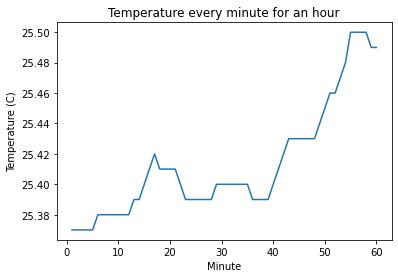

In [7]:
plt.plot(hour_data[1:, 0], hour_data[1:,1])
plt.xlabel('Minute')
plt.ylabel('Temperature (C)')
plt.title("Temperature every minute for an hour")

---

<h2 style="text-align: center;">Air Pressure</h2>

Air pressure readings are taken in hectoPascals.

### Current Air Pressure Readings:

The following line uses one of functions defined above to print the current air pressure.

In [19]:
printData("pres")

999.77 hPa


The following line uses one of the functions defined above to take an air pressure reading every second for the specified number of seconds.  
Change the first parameter to adjust the number of readings that are taken.

[-1, 999.75, 999.76, 999.76, 999.75, 999.76, 999.78, 999.79, 999.78, 999.77]


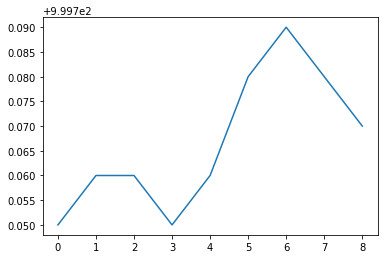

In [20]:
plot_data(10,"pres")

### Previously Recorded Data:

The following chunk plots the air pressure data from `hourData.csv` using the matplotlib library.

Text(0.5, 1.0, 'Air Pressure every minute for an hour')

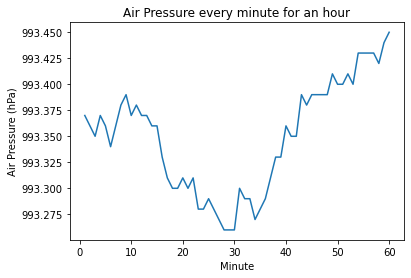

In [13]:
plt.plot(hour_data[1:, 0], hour_data[1:,2])
plt.xlabel('Minute')
plt.ylabel('Air Pressure (hPa)')
plt.title("Air Pressure every minute for an hour")

---

<h2 style="text-align: center;">Humidity</h2>

Humidity reading in terms of percent relative humidity.

### Current Humidity Readings:

The following line uses one of functions defined above to print the current humidity.

In [22]:
printData("hum")

62.84 hPa


The following line uses one of the functions defined above to take a humidity reading every second for the specified number of seconds.  
Change the first parameter to adjust the number of readings that are taken.

[62.804, 62.842, 62.808, 62.774, 62.737, 62.704, 62.685, 62.659, 62.659, 62.617]


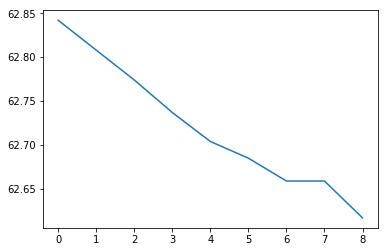

In [23]:
plot_data(10,"hum")

### Previously Recorded Data:

The following chunk plots the humidity data from `hourData.csv` using the matplotlib library.

Text(0.5, 1.0, 'Humidity every minute for an hour')

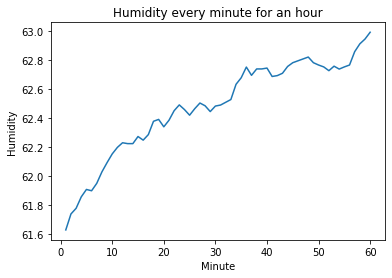

In [16]:
plt.plot(hour_data[1:, 0], hour_data[1:,3])
plt.xlabel('Minute')
plt.ylabel('Humidity')
plt.title("Humidity every minute for an hour")

---

<h2 style="text-align: center;">Gas Resistance</h2>

Gas resistance readings are taken in Ohms.

### Current Gas Resistance Readings:

The following line uses one of functions defined above to print the current gas resistance.

In [25]:
printData("res")

35857.57 Ohms


The following line uses one of the functions defined above to take a gas resistance reading every second for the specified number of seconds.  
Change the first parameter to adjust the number of readings that are taken.

In [ ]:
plot_data(30,"res")

### Previously Recorded Data:

The following chunk plots the gas resistance data from `hourData.csv` using the matplotlib library.

Text(0.5, 1.0, 'Air Resistance every minute for an hour')

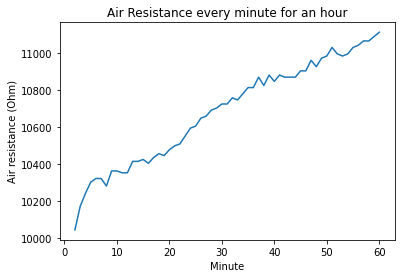

In [18]:
plt.plot(hour_data[2:, 0], hour_data[2:,4])
plt.xlabel('Minute')
plt.ylabel('Air resistance (Ohm)')
plt.title("Air Resistance every minute for an hour")

Text(0.5, 1.0, 'Air Resistance every minute for two hours')

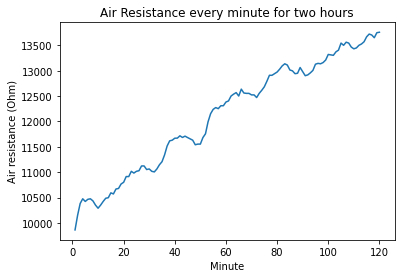

In [19]:
plt.plot(nano_data[2:, 0], nano_data[2:,4])
plt.xlabel('Minute')
plt.ylabel('Air resistance (Ohm)')
plt.title("Air Resistance every minute for two hours")

---

**If you haven't done so, look at the `setup.md` file in the `SageEdu/microphone/` and  `SageEdu/camera/` directories to learn how to use each of the sensors**
- [Camera Setup](https://github.com/ddiLab/SageEdu/blob/main/camera/setup.md)
- [Microphone Setup](https://github.com/ddiLab/SageEdu/blob/main/microphone/setup.md)